# Assignment 

In this assignment, we will design a regression model by using the [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset from Kaggle. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. 

We will familiarize ourselves with the data by performing EDA to identify trends, spot anaomiles, select features, and more. Once this stage is complete, we will split our data into train and test sets where 20% of the data resides in the test set. Then, we will build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. We will also use k-fold cross-validation to select the best hyperparameters for our models. Once we evaluate our best model on the test set, we will introduce addition factors that may affect house prices. 


In [1]:
# Libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA 
from sklearn import linear_model
from sqlalchemy import create_engine
import warnings
import missingno as msno


# Import data

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Data Cleaning and Formatting 

### Load in the Data  and Examine

First, we will create a copy of the original house price dataframe so that we can manipulate and clean the data without disturbing the original dataset. We will begin by loading the data and format the column names by stripping spaces and convert to lowercase. 

In [2]:
# Rename columns that contain trailing spaces

df = houseprices_df.copy()

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

print(df.shape)

df.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
# Datatypes 

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

There are 81 attributes and 1,460 rows in this dataset. Currently, there are 43 categorical and 38 continous varibles describing aspects of houses sold in Ames, Iowa. There are a couple of date columns and an id column that were entered as integers. Since the focus of this assignment is predicting sale price and not working with a time series dataset, we will convert the columns to strings. 

In [4]:
# Convert to string 

convert_type = ['id','yearbuilt','yearremodadd','mosold','yrsold']

df[convert_type] = df[convert_type].astype(str)

In [5]:
num_var = df.select_dtypes(['int64', 'float64']).columns
print('There are {} numeric varibles'.format(len(num_var)))

cat_var = df.select_dtypes(['object']).columns
print('There are {} categorical varibles'.format(len(cat_var)))

There are 33 numeric varibles
There are 48 categorical varibles


After converting columns to the correct types, we now have 33 numeric and 48 categorical variables. 

Let's get a basic description of the dataset by viewing summary statistics.

In [6]:
# Dataframe statistics 

df.describe()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,saleprice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,1057.429452,...,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,181.066207,456.098091,161.319273,441.866955,438.705324,...,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,...,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,...,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,...,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000


In [7]:
df.describe(include=['object'])

,id,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,...,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,mosold,yrsold,saletype,salecondition
count,1460,1460,1460,91,1460,1460,1460,1460,1460,1460,...,1379,1379,1460,7,281,54,1460,1460,1460,1460
unique,1460,5,2,2,4,4,2,5,3,25,...,5,5,3,3,4,4,12,5,9,6
top,249,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,TA,TA,Y,Gd,MnPrv,Shed,6,2009,WD,Normal
freq,1,1151,1454,50,925,1311,1459,1052,1382,225,...,1311,1326,1340,3,157,49,253,338,1267,1198


Here are some initial observations:
 - Lot area varies drastically from 1,300 square feet (2 bedroom) to 215,245 square feet (mega-mansion).
 - The average house has a basement of 1,057 square feet. 
 - Majority of garages can store up to 2 cars.
 - The average pool area is around 2 square feet, which indicates that these houses probably do not have a pool. This may be typical of a house in Iowa. 
 - The sale prices ranges from \\$34,900 to \\$755,000. The average price for a house was around \$180,921. 
  
 - These houses were built from 1872 to 2010. The average house in this dataset was built around 1971.
 - Houses in Northern Ames neighborhood were sold the most. 
 - The data captures houses sold from 2006 to 2010. Summer months, particularly June 2009 was the most popular buying season.


### Missing Values 
After correcting column data types, let's take a look at missing data. Questions that we should keep in mind include how prevalent is missing data and if these values are missing at random. Answering these questions will help us detect potential bias in data collection and uncover truths. 

In [8]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values_table(df)

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
poolqc,1453,99.5
miscfeature,1406,96.3
alley,1369,93.8
fence,1179,80.8
fireplacequ,690,47.3
lotfrontage,259,17.7
garagetype,81,5.5
garageyrblt,81,5.5
garagefinish,81,5.5
garagequal,81,5.5


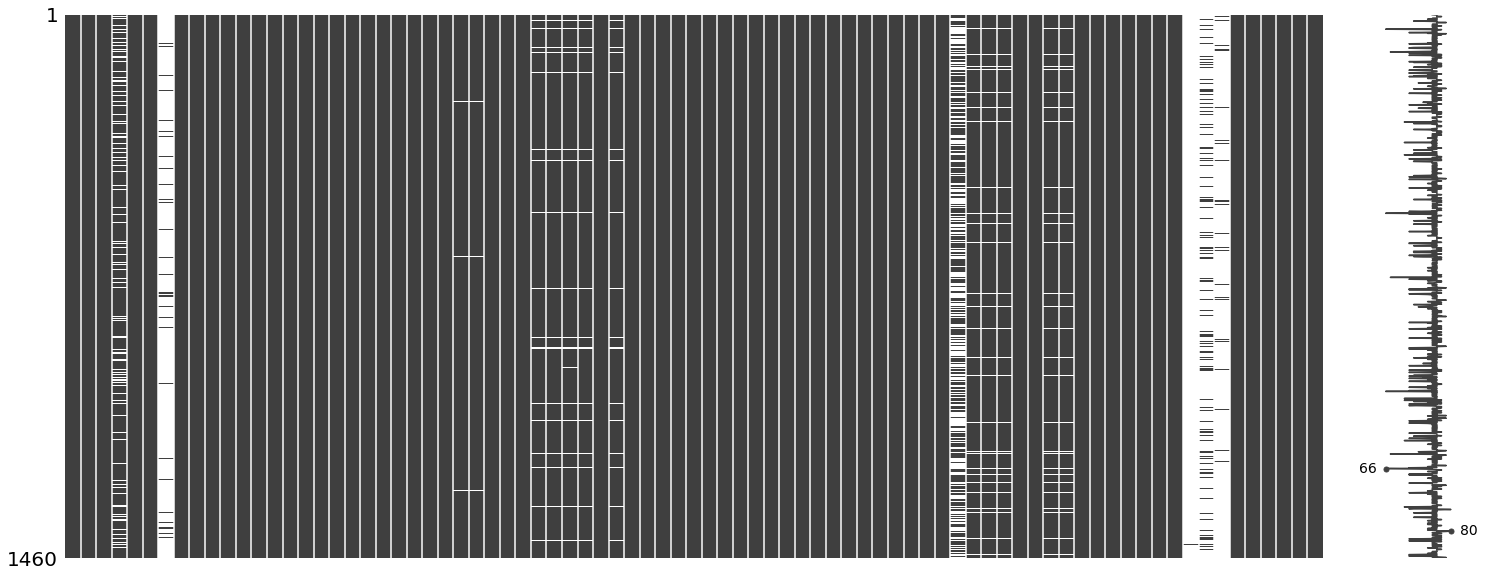

In [10]:
# Create nullity matrix for missing values 

msno.matrix(df)

We can observe that the top 5 variables in the table are missing more than 40% of datapoints. Since these are categorical data, we'll impute no inplace of NA.  With the remaining variables, we can impute missing values with their respective mode. 


In [11]:
# Get columns with >= 40% missing

missing_df = missing_values_table(df)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 40].index)
print('We will impute %d columns.' % len(missing_columns))

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.
We will impute 5 columns.


In [12]:
# Repalce NA with None

df[missing_columns] = df[missing_columns].fillna('None')

Now, we will fill remaining missing values with the mode. 

In [13]:
# Imputation by mode

df = df.fillna(df.mode().iloc[0])

Let's check to see whether the null values were missing at random by comparing descriptive statistics before and after dropping the values. 

In [14]:
# Check to see remaining null values 

missing_values_table(df)

Your selected dataframe has 81 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [15]:
# Dataset before drop values 

houseprices_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [16]:
# Dataset after drop values 
df.describe()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,saleprice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,68.267123,10516.828082,6.099315,5.575342,103.117123,443.639726,46.549315,567.240411,1057.429452,...,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890
std,42.300571,22.356355,9981.264932,1.382997,1.112799,180.731373,456.098091,161.319273,441.866955,438.705324,...,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,...,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,50.000000,63.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,...,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,...,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000


There doesn't appear to be a drastic change in the means after dropping the null values so we will assume that the data was completely missing at random. 
  

## Exploring Data 

Now that we have "cleaned" the data, we can begin exploratory data analysis. EDA is an iterative process to explore the data and summarize characteristics by calculating statistics or visualize methods.  The purpose of EDA is gain an understanding of the data by identifying trends, anomalies, or relationships that might be helpful when making decisions in the modeling process. We can starts out with a high-level overview. If we find an interesting trend, then we can narrow in our focus.



### Univariate Analysis 

We will begin EDA by exploring individual variables, particularly sale price since it is our target variable. 

Text(0.5, 1.0, 'Sale Price')

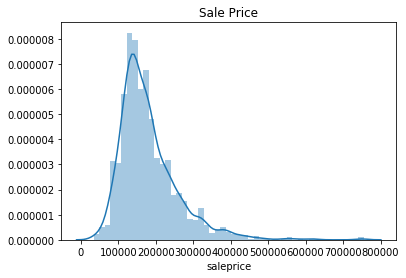

In [17]:
# Plot sale price 

sns.distplot(df.saleprice)
plt.title('Sale Price')

We can observe that the distribution of sale price is heavely skewed to the right. Let's look at some statistics for this feature. 

In [18]:
df['saleprice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

In [19]:
print("Skewness: %f" % df['saleprice'].skew())
print("Kurtosis: %f" % df['saleprice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


The statistics offers insight on the central tendencies of the distribution. The average house in Ames, Iowa sold for \\$180,921 while the median of the distribution is around \\$163,300. That there is also a large price gap between 75% of house prices being listed under \\$214,000 and the maximum value of \\$755,000. A __skewness__ of 1.88 confirms that sale price not normally distributed and is right skewed. A __kurtosis__ of 6.54 indicates a heavy tail distribution that is not symmetrical. We will transform the data to treat skewness later. 

Below are the returned rows for house prices that were more than \\$700,000. These data points will probably be extreme outliers in our dataset. For now, we will keep them aside, but may consider dropping them to increase our accuracy percentage when trying to improve our model's performance.



In [20]:
df.loc[df['saleprice']>=700000]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000


### Removing Outliers

Although outliers contain meaningful information, linear regression machine learning models are sensitive to extreme values so we will exclude some extreme values. We will set the threshold at 3 standard deviations as it will allow us to retain 99% of the dataset. Then, we will replace the them with the threshold value. 

In [21]:
#Features with Outliers 

for column in num_var:
    if df[column].quantile(.9973)<df[column].max():
        print(column)
        print('99th Percentile',df[column].quantile(.9973))
        print('Max',df[column].max())
        print('Outliers Present in Column {}'.format(column))
        print('')
    elif df[column].quantile(0)>df[column].min():
        print(column)
        print('99th Percentile',df[column].quantile(.9973))
        print('Min',df[column].min())
        print('Outliers Present in Column {}'.format(column))
        print('')
    else:
        pass

lotfrontage
99th Percentile 174.0
Max 313.0
Outliers Present in Column lotfrontage

lotarea
99th Percentile 73455.35159998978
Max 215245
Outliers Present in Column lotarea

masvnrarea
99th Percentile 1115.8497999999968
Max 1600.0
Outliers Present in Column masvnrarea

bsmtfinsf1
99th Percentile 1915.6543999999558
Max 5644
Outliers Present in Column bsmtfinsf1

bsmtfinsf2
99th Percentile 1080.3034999999988
Max 1474
Outliers Present in Column bsmtfinsf2

bsmtunfsf
99th Percentile 2042.242799999999
Max 2336
Outliers Present in Column bsmtunfsf

totalbsmtsf
99th Percentile 3096.67079999999
Max 6110
Outliers Present in Column totalbsmtsf

firstflrsf
99th Percentile 2649.0854999999387
Max 4692
Outliers Present in Column firstflrsf

secondflrsf
99th Percentile 1622.2294999999574
Max 2065
Outliers Present in Column secondflrsf

lowqualfinsf
99th Percentile 513.0606999999998
Max 572
Outliers Present in Column lowqualfinsf

grlivarea
99th Percentile 3668.8222999998416
Max 5642
Outliers Present i

In [22]:
def outlier_table(df):
    for column in df.select_dtypes(['int64', 'float64']).columns:
        if df[column].quantile(.9973)<df[column].max():
            threshold = df[column].quantile(.9973)
            df[column] = np.where(df[column] > threshold, int(round(threshold)),df[column])
            if df[column].quantile(0)>df[column].min():
                threshold = df[column].min()
                df[column] = np.where(df[column] < threshold, int(round(threshold)),df[column])
        
        elif df[column].quantile(0)>df[column].min():
            threshold = df[column].min()
            df[column] = np.where(df[column] < threshold, int(round(threshold)),df[column])
        else:
            pass
    return df
            

In [24]:
df2 = df.copy()
df2 = outlier_table(df2)

df2.loc[df2['saleprice']>=584676]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,584677
898,899,20,RL,100.0,12919,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,3,2010,New,Partial,584677
1169,1170,60,RL,118.0,35760,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,7,2006,WD,Normal,584677
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,521,Ex,MnPrv,None,0,7,2007,WD,Abnorml,584677


In [25]:
df.loc[df['saleprice']>=584676]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,755000
898,899,20,RL,100.0,12919,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,3,2010,New,Partial,611657
1169,1170,60,RL,118.0,35760,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000


### Multivariable Analysis

Next, we'll explore the remaining variables. As previously mentioned in the primary stage of loading the data, this dataset contains two types of features, numeric and categorical. 

__Numerical variables__ are data in numeric form such as integers and floats. Numeric values can be classified into discrete and continuous variables. Discrete numerical variables are whole number values such as the number of rooms in a house. Meanwhile continuous numerical variables may contain any value within some range like sale prices of houses. 

__Categorical variables__ are essentially small groups of categories. Categorical variables can be further categorized into ordinal and nominal variables. Ordinal categorical variables have meaningful order such as a scale of overall quality finish of a house. In contrast, nominal categorical variables purely assign data to groups without intrinsic ordering. We have variables of this type in our dataset such as sale condition, land contour, and zoning classification. 
 

In [ ]:
# Numeric variables 

df2.select_dtypes(['int64', 'float64']).columns

In [ ]:
# Categorical variables 

df2.select_dtypes(['object']).columns

### Looking for Relationships

To determine which explanatory variables we might select for our prediction model, we will explore the correlation between sale price and other variables. __Correlation__ refers to a mutal association between variables. Variables that have a strong correlation, whether it being positive or negative, will affect the target variable. 



In [ ]:
# Correlation between sale price and numeric variables 

corrmat = df2.corr()
print(corrmat['saleprice'].sort_values(ascending = False),'\n')

In [ ]:
most_corr = df2.loc[:,['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf',
                    'firstflrsf','fullbath','totrmsabvgrd','garageyrblt','saleprice']]


The most correlated variables to sale price:
 - overallqual: overall material and finish quality
 - grlivarea: above grade (ground) living area square feet
 - garagecars: size of garage in car capacity
 - garagearea: size of garage in square feet
 - totalbsmtsf: total square feet of basement area
 - firstflrsf: first floor square feet
 - fullbath: full bathrooms above grade 
 - totrmsabvgrd: total rooms above grade (does not include bathrooms)
 - garageyrblt: year garage was built

These results make sense since buyers would be interested in knowing the general living space, quality of the house, and garage capacity.  

Let's see how each variable relates to sale price.

In [ ]:
sns.boxplot(x='overallqual', y="saleprice", data=df2)
plt.title('Sale Price vs. Overall Quality')

As one would expect, there is a linear relationship relationship between overall quality and sale price. Generally, as the quality of an item increases, the price will follow in the same direction. 

In [ ]:
sns.regplot(x="grlivarea", y="saleprice", data=df2)
plt.title('Sale Price vs. Above Grade Living Area (SF)')

This plot implies that is a positive correlation between the increase of above grade living area and sale price. This is plausible since larger houses will cost more. However, there are two data points in the lower right corner that appears to be outliers. Houses with living areas more than 4,000 square feet should cost more than houses with smaller living areas. We will manually remove them.

In [ ]:
# Removing outliers manually (Two points in the bottom right)

#df = df.drop(df[(df['grlivarea']>4000)  & (df['saleprice']<300000)].index).reset_index(drop=True)

In [ ]:
sns.boxplot(x='garagecars', y="saleprice", data=df2)
plt.title('Sale Price vs. Garage Cars')

There appears to be a price increase from zero to three garage cars and then the price suddenly drops at four garage cars. This seems suspicious so we'll drop these outliers. 

In [ ]:
# Removing outliers manually (More than 4-cars, less than $300k)

#df = df.drop(df[(df['garagecars']>3) & (df['saleprice']<300000)].index).reset_index(drop=True)

In [ ]:
sns.regplot(x="totalbsmtsf", y="saleprice", data=df2)
plt.title('Sale Price vs. Garage Area')

Similar to above grade living area, we also see two data points at the lower right corner of this plot. As garage area increase, the price should also increase. We will also drop these outliers.

In [ ]:
# Removing outliers manually (More than 1000 sqft, less than $300k)

#df = df.drop(df[(df['garagearea']>1000) & (df['saleprice']<300000)].index).reset_index(drop=True)

In [ ]:
sns.regplot(x="garagearea", y="saleprice", data=df2)
plt.title('Sale Price vs. Total square feet of Basement area')

In [ ]:
sns.regplot(x="firstflrsf", y="saleprice", data=df2)
plt.title('Sale Price vs. First Floor Area (SF)')

In [ ]:
sns.boxplot(x='fullbath', y="saleprice", data=df2)
plt.title('Sale Price vs. Full Bathrooms')

The average price of a house with zero full bathrooms is higher than a house with one full bathroom. This maybe due to missing data for full baths. 

In [ ]:
sns.boxplot(x='totrmsabvgrd', y="saleprice", data=df2)
plt.title('Sale Price vs.  Total Rooms above grade')

In [ ]:
sns.lineplot(x="garageyrblt", y="saleprice", data=df2)
plt.title(' Sale Price vs. Garage Year Built')

We can see that recently garages built after 1980s cost more than ones built before 1980s.

Let's continue to plot common factors a buyer might focus on when purchasing a house, such as the house style, utilies type, garage space, and overall quality finish of the house. 

In [ ]:
top_var = df.loc[:,['overallqual','grlivarea','garagecars',
                    'garagearea','totalbsmtsf','firstflrsf','saleprice']]
sns.pairplot(top_var, y_vars="saleprice", x_vars=top_var.columns.values)

We can observe that most of the variables have somewhat of a linear relationship with sale price. The scatter plot also offers insight in possible outliers. We can see outliers on the far right for ground living area, garage area, total basement area, first floor, and sale price. 



With the variables identified above, we will continue to explore their relationship with sale price through scatter plots. 

In [ ]:
# Plot variables 

col = ['housestyle','utilities','garagearea','overallqual']

plt.figure(figsize=(15,75))

for i in range(len(col)):
    plt.subplot(18,2,i+1)
    plt.hist(df[col[i]])
    plt.title(col[i])

plt.show()

We can see that all variables are not normally distributed. In the first graph, most data points are concentrated around 1 and 2 story houses, which is typical of house styles. There are a couple of values that fall in the 2.5 unfinished and finished bins, possibly pulling the distribution to the right. Utilities appears to be a binary variable with all data points in the all public utilities (electric, gas, water,& septic) bin. While garage area is positively skewed, the overall qualities of the houses show skewing towards the left.

These outliers can throw a model since it causes the distribution to skew. We will deal with extreme values before modeling. 

NOTE: I have not dropped any outliers yet.  

In [ ]:
# Create function to detect outliers by using standard deviation 

def out_std(s):
    # calculate summary statistics
    data_mean, data_std = s.mean(), s.std()
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in s if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    print(outliers)
    outliers_removed = [x for x in s if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))


In [ ]:
# Outlier values 

out_std(df['overallqual'])
out_std(df['grlivarea'])
out_std(df['garagecars'])
out_std(df['garagearea'])
out_std(df['totalbsmtsf'])
out_std(df['firstflrsf'])

In [ ]:
# Replacing outliers with median values 

median = df['overallqual'].median()
df["overallqual"] = np.where(df["overallqual"] == 1, median,df['overallqual'])    

median = df['grlivarea'].median()
df["grlivarea"] = np.where(df["grlivarea"] >= 3112, median,df['grlivarea'])

median = df['garagearea'].median()
df["garagearea"] = np.where(df["garagearea"] >= 1134, median,df['garagearea'])  

median = df['totalbsmtsf'].median()
df["totalbsmtsf"] = np.where(df["totalbsmtsf"] >= 2392, median,df['totalbsmtsf'])  

median = df['firstflrsf'].median()
df["firstflrsf"] = np.where(df["firstflrsf"] >= 2392, median,df['firstflrsf'])  

## Feature Engineering
In this step, we will select features for our linear regression model. First, let's start with the numeric values. Previously, we identified 6 numeric variables that are highly correlated to sale price. We will use a heat map to check if the variables on highly correlated to each other before continuing. 

#### Feature 1: Numeric values 

In [ ]:
# Heatmap of most correlated variables 

corrmat = top_var.corr()
sns.heatmap(corrmat)

The variables look relatively independent of each other. Let's try running our first linear regression model with only numeric variables. 

#### Feature 2: Dummy Variables 
We will be introducing the following categorical variables to the model: general zoning classification (mszoning) and house style.

In [ ]:
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.housestyle, prefix="style", drop_first=True)], axis=1)


dummy_column_names = list(pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.housestyle, prefix="style", drop_first=True).columns)

#### Feature 3: Log transformation 

To increase the fit of our model, we will perform log transformation on sale price since it is highly skewed to the right. 

#### Feature 4: New variables 

We'll also introduce a new variable by combining total basement area, first, and second floor area as total square feet. Lastly, we will add the interaction between total square feet and overall quality of the house.

### Iteration 1

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes
X = df[['overallqual','grlivarea','garagearea','totalbsmtsf','firstflrsf']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

LinearRegression fit method runs the OLS algorithm by default. Since we get the parameters using OLS, we can write our estimated model:

$$ saleprice = -121239.52 + 27,285.82\_overallqual + 37.28\_grlivarea + 62.96\_garagearea + 27.38\_totalbsmtsf + 19.03\_firstflrsf $$

In [ ]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

NOTE: I am not sure of how I am suppose to interpet the results. 

## Iteration 2 

The variables look relatively independent of each other. Let's continue to explore the categorical variables. We will need to convert strings to numerical values. We will use __one hot encoding__ to separate variables into numbers for each unique value. 

In [ ]:
# Create dataframe of categorical variables 

cat_var_dum = pd.get_dummies(cols = cat_var.columns, drop_first=True)
cat_var_dum.head()

## Assumption of linear regression

Now that we have calculated coefficients for linear regression, we must see if the data and model meets Gauss Markov Assumptions before we can consider the estimated coeffiecents to be valid and reliable.

### Assumption one: linearity of the model in its coefficients
The first assumption that must be met is that the target variable should be a linear function of the model's coefficients.

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['overallqual']]

# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['grlivarea']]

# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['totalbsmtsf']]


# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['firstflrsf']]

# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['garagearea']]

# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

We can see that most of the coeefficents are able to capture a quadratic relationship between the target and the feautres.

### Assumption two: the error term should be zero on average
The second assumption states that the expectation of our error term in our population, given our x term, has to be equal to zero. The error term should not help to predict variation of the target variable.

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['overallqual','grlivarea','garagearea','totalbsmtsf','firstflrsf']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the sale price model is: {}".format(np.mean(errors)))

Since, we include the constant term in the model, the average of the model's error is effectively zero.

### Assumption three: homoscedasticity
The third assumption describes the distribution of errors along the OSL line. A model is homoscedastic.

In [ ]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

There appears to be higher variance among predicted values than our target variable. This would imply that our errors are not homoscedastic.

We will also use Bartlett and Levene test for homoscedastic.  The null hypothesis for both tests is that the errors are homoscedastic.

In [ ]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

### Assumption four: low multicollinearity
Individual features should be weakly correlated to one another or non-existent. 

In [ ]:
X.corr()

We can see that all the variables are weakly correlated to one another.

### Assumption five: error terms should be uncorrelated with one another
Error terms should be uncorrelated with one another.

In [ ]:
plt.plot(errors)
plt.show()

It seems that the error terms of our model are uncorrelated with each other.

### Assumption six: features shouldn't be correlated with the errors
The last assumption is satisfying exogeneity which states that the regressors being calculated should not be perfectly correlated with the error term. If this assumption is not met, the coefficients would be biased.

### Multivariate normality
Although normality of erros is not required to apply OLS, the error terms must be normally distributed to measure the statistical significance of our regression model.

In [ ]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

As can be seen in the charts above, our errors are not normally distributed exactly. But the QQ plot and the histogram imply that the distribution is not very far away from normal.

In [ ]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

The p-values of both tests indicate that our errors are not normally distributed.